In [1]:
import pandas as pd
import datetime 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from datetime import datetime

## Pipeline

1. Data Preparation:
   - Load and preprocess data.
   - Create lagged features for power consumption and align them with the forecasted temperature data for the next 24 hours.
   - Split data into train, validation, and test sets
2. Model Definition:
   - Use the TCN architecture, which employs causal convolutions to ensure predictions only depend on past data.
3. Training:
   - Define a loss function and optimizer.
   - Train the model using the training set, and monitor validation loss to prevent overfitting.
8. Evaluation:
   - Predict the next 24 hours on the test set.
   - Compare TCN predictions with SARIMA using evaluation metrics like RMSE, MAE, and MAPE.

In [3]:
# Save current directory
current_directory = os.getcwd()

# Set print options to suppress scientific notation and show 3 decimal places
np.set_printoptions(suppress=True, precision=5)
pd.options.display.float_format = '{:.5f}'.format

# Suppress all warnings globally
import warnings
warnings.filterwarnings("ignore")

In [4]:
file_path = os.path.join(current_directory, 'data_augmented/X_small.csv')
X_small = pd.read_csv(file_path, index_col = 0)

file_path = os.path.join(current_directory, 'data_augmented/timestamps.csv')
timestamps = pd.read_csv(file_path, index_col = 0)

file_path = os.path.join(current_directory, 'data_augmented/temperature.csv')
temperature = pd.read_csv(file_path, index_col = 0)

In [5]:
df = X_small 

In [6]:
df['timestamp'] = timestamps
df.set_index("timestamp", inplace=True)

df.index = pd.to_datetime(df.index)
df = df.asfreq('H')  # 'H' for hourly frequency

In [7]:
def prepare_tcn_features(df, target_col, window_length=168, forecast_horizon=24):
    """
    Prepares the feature and target tensors for TCN.

    Parameters:
        df (pd.DataFrame): Input DataFrame with historical data.
        power_col (str): Column name for power consumption.
        temp_col (str): Column name for temperature.
        window_length (int): Length of the temporal window (168 for 7 days).
        forecast_horizon (int): Forecast horizon (24 for next 24 hours).

    Returns:
        np.ndarray: Feature tensor of shape (num_samples, window_length, num_features).
        np.ndarray: Target tensor of shape (num_samples, forecast_horizon).
        pd.DatetimeIndex: Timestamps corresponding to each sample.
    """
    df = df.copy()

    # Prepare features and targets
    X, y = [], []
    timestamps = []

    for i in range(len(df) - window_length - forecast_horizon + 1):
        # Extract historic features
        features = df.iloc[i:i + window_length].values  # (window_length, num_features)
        X.append(features)

        # Extract target (next 24 hours of power consumption)
        y.append(df.iloc[i + window_length:i + window_length + forecast_horizon][target_col].values)

        # Timestamps for the target period
        timestamps.append(df.index[i + window_length])

    return np.array(X), np.array(y), pd.DatetimeIndex(timestamps)

In [8]:
df

,power_consumption,ghi,temp,wind,is_weekend,is_spring,is_summer,is_autumn,is_winter,is_holiday,is_daylight
timestamp,,,,,,,,,,,
2022-04-13 10:00:00+00:00,0.21837,2.31866,0.44842,-0.83739,0,1,0,0,0,0,1
2022-04-13 11:00:00+00:00,-0.11143,2.09107,0.56725,-0.36810,0,1,0,0,0,0,1
2022-04-13 12:00:00+00:00,-0.16639,1.98543,0.69246,0.11499,0,1,0,0,0,0,1
2022-04-13 13:00:00+00:00,-0.03585,1.27027,0.76656,0.01837,0,1,0,0,0,0,1
2022-04-13 14:00:00+00:00,0.30769,1.71318,0.79978,-0.17487,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
2024-06-17 01:00:00+00:00,-1.06418,-0.65983,-0.05753,-0.23008,0,0,1,0,0,0,0
2024-06-17 02:00:00+00:00,-1.05848,-0.65983,-0.09075,-0.21628,0,0,1,0,0,0,0
2024-06-17 03:00:00+00:00,-1.02523,-0.65983,-0.07669,-0.25768,0,0,1,0,0,0,0


In [9]:
target_col = "power_consumption"
window_length = 168  # 7 days
forecast_horizon = 24  # Next 24 hours

# Reduce the feature space dimension
# df = df[['power_consumption', 'temp']]

# Add forecasted temperature data
# df['temp_forecast'] = temperature[window_length : len(df) + window_length]['temperature'].values

In [10]:
# Step 1: Train-Test Split
train_size = int(len(df) * 0.8)  # Determine initial train size based on 80%
initial_test_start = train_size  

while df.index[initial_test_start].hour != 11: # Adjust test start to align with the next occurrence of 11 AM
    initial_test_start += 1

final_test_end = len(df) - 1
while df.index[final_test_end].hour != 10: # Adjust test end to align with the last 10 AM in the dataset
    final_test_end -= 1

train = df.iloc[:initial_test_start]
test = df.iloc[initial_test_start:final_test_end+1]  # Include the last index

In [11]:
X, y, timestamps = prepare_tcn_features(df, target_col, window_length, forecast_horizon)
X_train, y_train, timestamps_train = prepare_tcn_features(train, target_col, window_length, forecast_horizon)
X_test, y_test, timestamps_test = prepare_tcn_features(test, target_col, window_length, forecast_horizon)

In [12]:
import torch
import torch.nn as nn

class TemporalConvNet(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size=3, dropout=0.2):
        """
        Temporal Convolutional Network for Power Consumption Forecasting.

        Parameters:
            input_size (int): Number of input features.
            output_size (int): Number of output features (forecast horizon).
            num_channels (list): Number of channels in each TCN layer.
            kernel_size (int): Size of the convolution kernel.
            dropout (float): Dropout rate.
        """
        super(TemporalConvNet, self).__init__()
        layers = []
        for i in range(len(num_channels)):
            in_channels = input_size if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]
            layers += [
                nn.Conv1d(in_channels, out_channels, kernel_size, stride=1, padding=(kernel_size - 1)),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], output_size)

    def forward(self, x):
        """
        Forward pass of the TCN.

        Input:
            x: Shape (batch_size, seq_length, input_size).
        Output:
            y: Shape (batch_size, output_size).
        """
        x = x.permute(0, 2, 1)  # Change to (batch_size, input_size, seq_length)
        x = self.network(x)
        x = x[:, :, -1]  # Take the last time step
        x = self.linear(x)
        return x


In [13]:
import torch

# Check if MPS (Metal Performance Shaders) is available
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use the MPS device for Apple Silicon
elif torch.cuda.is_available():
    device = torch.device("cuda")  # Use CUDA if available
else:
    device = torch.device("cpu")  # Default to CPU if no GPU backend is available

print(f"Using device: {device}")

Using device: cpu


In [14]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for batching
from torch.utils.data import DataLoader, TensorDataset

batch_size = 128
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize the TCN model
input_size = X.shape[2]  # Number of features per time step
output_size = y.shape[1]  # Forecast horizon (24 hours)
hidden_channels = [64, 128, 64]  # Number of channels in hidden layers

model = TemporalConvNet(input_size, output_size, hidden_channels, kernel_size=3, dropout=0.2).to(device)

# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss / len(train_loader):.4f}")

# Test the model
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor.to(device))
    test_loss = criterion(test_predictions, y_test_tensor.to(device)).item()
print(f"Test Loss: {test_loss:.4f}")

Epoch 1, Loss: 0.6115
Epoch 2, Loss: 0.4404
Epoch 3, Loss: 0.4138
Epoch 4, Loss: 0.4037
Epoch 5, Loss: 0.3959
Epoch 6, Loss: 0.3896
Epoch 7, Loss: 0.3874
Epoch 8, Loss: 0.3823
Epoch 9, Loss: 0.3795
Epoch 10, Loss: 0.3766
Test Loss: 0.4553


In [15]:
test_predictions_np = test_predictions.cpu().detach().numpy()  # (num_test_samples, forecast_horizon)

num_samples, forecast_horizon = test_predictions_np.shape  

aligned_matrix = np.full((num_samples, num_samples+forecast_horizon-1), np.nan)
for i in range(num_samples):  
    aligned_matrix[i, i:i + forecast_horizon] = test_predictions_np[i] 

column_names = [timestamps_test[0] + pd.Timedelta(hours=i) for i in np.arange(1,num_samples+forecast_horizon)]
aligned_df = pd.DataFrame(aligned_matrix, index=timestamps_test, columns=column_names)
aligned_df

,2024-01-17 12:00:00+00:00,2024-01-17 13:00:00+00:00,2024-01-17 14:00:00+00:00,2024-01-17 15:00:00+00:00,2024-01-17 16:00:00+00:00,2024-01-17 17:00:00+00:00,2024-01-17 18:00:00+00:00,2024-01-17 19:00:00+00:00,2024-01-17 20:00:00+00:00,2024-01-17 21:00:00+00:00,...,2024-06-16 02:00:00+00:00,2024-06-16 03:00:00+00:00,2024-06-16 04:00:00+00:00,2024-06-16 05:00:00+00:00,2024-06-16 06:00:00+00:00,2024-06-16 07:00:00+00:00,2024-06-16 08:00:00+00:00,2024-06-16 09:00:00+00:00,2024-06-16 10:00:00+00:00,2024-06-16 11:00:00+00:00
2024-01-17 11:00:00+00:00,1.86095,1.73706,1.58517,1.41059,1.25993,1.11552,0.93050,0.75926,0.58939,0.42693,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-17 12:00:00+00:00,NaN,2.09690,1.95991,1.79374,1.59820,1.42870,1.26193,1.04232,0.83794,0.63168,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-17 13:00:00+00:00,NaN,NaN,1.93809,1.79992,1.63952,1.44911,1.28671,1.12773,0.92127,0.73218,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-17 14:00:00+00:00,NaN,NaN,NaN,1.88383,1.76337,1.60817,1.43760,1.29084,1.15400,0.98022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-17 15:00:00+00:00,NaN,NaN,NaN,NaN,1.89644,1.79459,1.64732,1.50626,1.38192,1.26405,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-15 07:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.41075,-0.40209,-0.41009,-0.41771,-0.42857,-0.45560,NaN,NaN,NaN,NaN
2024-06-15 08:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.62764,-0.62047,-0.60774,-0.61220,-0.62298,-0.63624,-0.66360,NaN,NaN,NaN
2024-06-15 09:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.66050,-0.63314,-0.62374,-0.60714,-0.60807,-0.61758,-0.63204,-0.66010,NaN,NaN
2024-06-15 10:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.87460,-0.83100,-0.79873,-0.78438,-0.76470,-0.76702,-0.78475,-0.80904,-0.83954,NaN


In [16]:
def day_ahead_forecast(y_pred, y_true, prediction_timestamps, forecast_horizon=24):
    """
    Generate direct day-ahead forecasts without rolling mean.
    Predicts at time k the next k+24 hours and aligns predictions with test timestamps.
    """
    predictions = []  # Store predictions for each 24-hour window
    actuals = []

    # Loop through the test set in steps of 24 (non-overlapping)
    for i in range(0, len(y_pred), forecast_horizon):
        
        predictions.append(y_pred[i])
        actuals.append(y_true[i])

    
    # Convert predictions and timestamps to a Pandas Series
    predictions_series = pd.Series(
        np.concatenate(predictions),  # Flatten the list of forecasts
        index=prediction_timestamps  # Align with timestamps
    )
    
    # Convert predictions and timestamps to a Pandas Series
    actuals_series = pd.Series(
        np.concatenate(actuals),  # Flatten the list of forecasts
        index=prediction_timestamps  # Align with timestamps
    )
    return predictions_series, actuals_series

In [17]:
def plot_results(pred, act, title):
    plt.figure(figsize=(12, 6))
    plt.plot(test.index[:len(pred)], act, label="Actual")
    plt.plot(test.index[:len(pred)], pred, label="Predicted", linestyle="--")
    plt.legend()
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Power Consumption")
    plt.grid()
    plt.show()

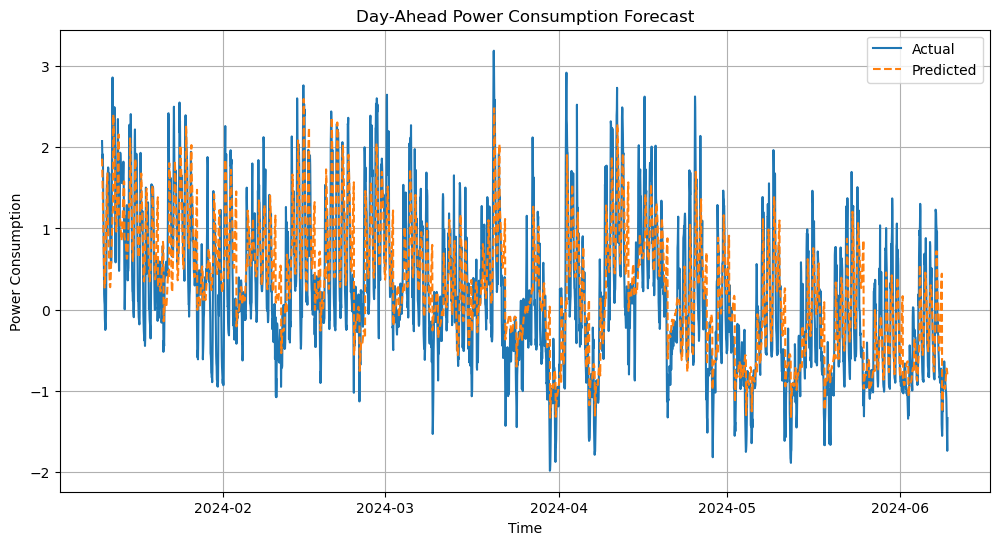

In [18]:
prediction_timestamps = [timestamps_test[0] + pd.Timedelta(hours=i) for i in np.arange(1,num_samples+forecast_horizon)]
y_pred = test_predictions_np
y_true = np.array(y_test)
predictions, actuals = day_ahead_forecast(y_pred, y_true, prediction_timestamps, 24)
plot_results(predictions, actuals, "Day-Ahead Power Consumption Forecast")

In [19]:
def plot_results_by_month(pred, act, title):

    pred.index = pd.to_datetime(pred.index)
    act.index = pd.to_datetime(act.index)

    # Group data by month
    months = pred.index.month.unique()
    num_months = len(months)

    # Create subplots
    fig, axes = plt.subplots(nrows=num_months, ncols=1, figsize=(50, 4 * num_months), sharex=False)
    if num_months == 1:  # If there's only one month, axes is not a list
        axes = [axes]
    
    for ax, month in zip(axes, months):
        # Filter data for the current month
        pred_month = pred[pred.index.month == month]
        act_month = act[act.index.month == month]
        
        # Plot the data
        ax.plot(act_month.index, act_month, label="Actual")
        ax.plot(pred_month.index, pred_month, label="Predicted", linestyle="--")
        
        # Customize the subplot
        ax.set_title(f"Month: {month}")
        ax.set_xlabel("Time")
        ax.set_ylabel("Power Consumption")
        ax.legend()
        ax.grid()

    # Add overall title and layout adjustment
    fig.suptitle(title, fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.97])  
    plt.show()

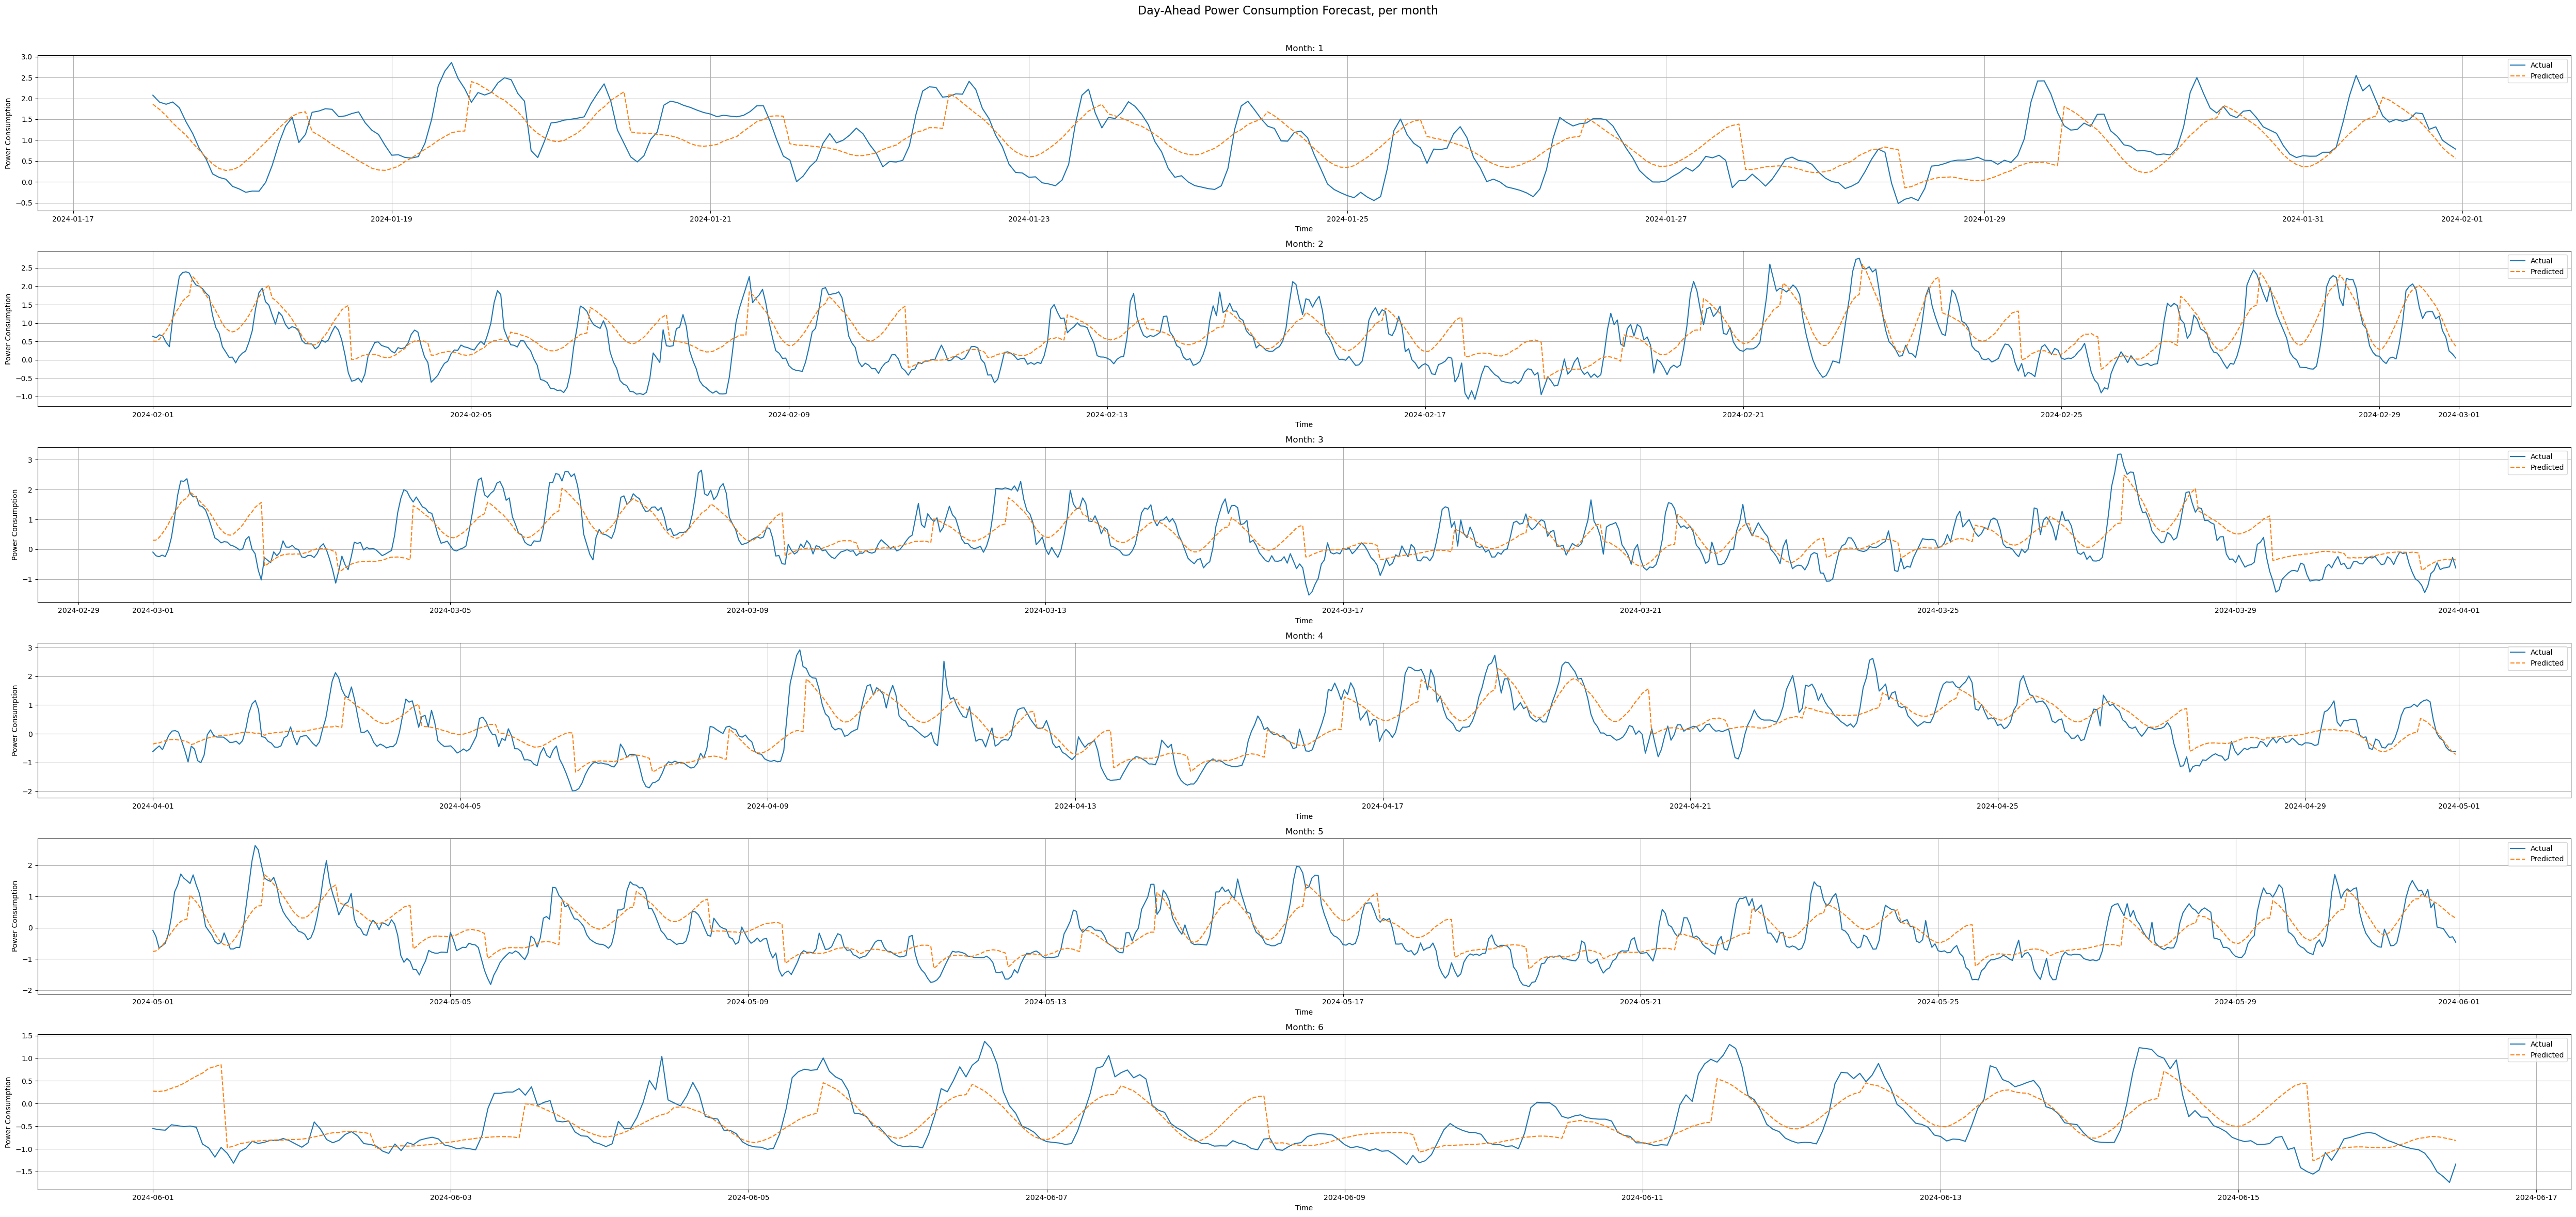

In [20]:
plot_results_by_month(predictions, actuals, "Day-Ahead Power Consumption Forecast, per month")

In [21]:
# MSE
from sklearn.metrics import mean_squared_error

# RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
    
# MAE
from sklearn.metrics import mean_absolute_error

# MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) # * 100

# ME
from sklearn.metrics import max_error

In [22]:
models = ['TCN prediction at 10 am', 'TCN predictions at all time steps']
error_dict = {'model': models,
              'RMSE': np.zeros(len(models)),
              'MAE': np.zeros(len(models)),
              'ME': np.zeros(len(models)),
              'MAPE': np.zeros(len(models))
    }
errors = pd.DataFrame(error_dict).set_index("model")
errors = pd.DataFrame(error_dict).set_index("model")

In [23]:
errors.loc[models[0], 'RMSE'] = root_mean_squared_error(actuals, predictions)
errors.loc[models[0], 'MAE'] = mean_absolute_error(actuals, predictions)
errors.loc[models[0], 'ME'] = max_error(actuals, predictions)
errors.loc[models[0], 'MAPE'] = mean_absolute_percentage_error(actuals, predictions)
errors

,RMSE,MAE,ME,MAPE
model,,,,
TCN prediction at 10 am,0.56839,0.42552,2.81161,2.80231
TCN predictions at all time steps,0.00000,0.00000,0.00000,0.00000


In [24]:
errors.loc[models[1], 'RMSE'] = root_mean_squared_error(y_true.flatten(), y_pred.flatten())
errors.loc[models[1], 'MAE'] = mean_absolute_error(y_true.flatten(), y_pred.flatten())
errors.loc[models[1], 'ME'] = max_error(y_true.flatten(), y_pred.flatten())
errors.loc[models[1], 'MAPE'] = mean_absolute_percentage_error(y_true.flatten(), y_pred.flatten())
errors

,RMSE,MAE,ME,MAPE
model,,,,
TCN prediction at 10 am,0.56839,0.42552,2.81161,2.80231
TCN predictions at all time steps,0.67478,0.51585,3.18162,3.30341


In [60]:
errors / np.max(errors, axis = 0)

,RMSE,MAE,ME,MAPE
model,,,,
TCN prediction at 10 am,0.84234,0.82489,0.88371,0.84831
TCN predictions at all time steps,1.00000,1.00000,1.00000,1.00000


In [25]:
def compute_picp_pinaw(y_true, y_lower, y_upper):
    """
    Computes PICP (Prediction Interval Coverage Probability) and 
    PINAW (Prediction Interval Normalized Average Width).
    
    Parameters:
        y_true (array-like): True values of the target variable.
        y_lower (array-like): Lower bounds of the prediction intervals.
        y_upper (array-like): Upper bounds of the prediction intervals.
    
    Returns:
        picp (float): Prediction Interval Coverage Probability.
        pinaw (float): Prediction Interval Normalized Average Width.
    """
    # Convert inputs to numpy arrays for easier manipulation
    y_true = np.array(y_true)
    y_lower = np.array(y_lower)
    y_upper = np.array(y_upper)
    
    # PICP: Proportion of true values within the bounds
    coverage = (y_true >= y_lower) & (y_true <= y_upper)  # Boolean array
    picp = np.mean(coverage)  # Average of the boolean array
    
    # PINAW: Average width of intervals, normalized by the range of y_true
    interval_widths = y_upper - y_lower
    pinaw = np.mean(interval_widths) / (np.max(y_true) - np.min(y_true))
    
    return picp, pinaw

In [26]:
# picp, pinaw = compute_picp_pinaw(y_true, y_lower, y_upper)

In [27]:
'''
def prepare_tcn_features(df, power_col, temp_col, window_length=168, forecast_horizon=24):
    """
    Prepares the feature and target tensors for TCN.

    Parameters:
        df (pd.DataFrame): Input DataFrame with historical data.
        power_col (str): Column name for power consumption.
        temp_col (str): Column name for temperature.
        window_length (int): Length of the temporal window (168 for 7 days).
        forecast_horizon (int): Forecast horizon (24 for next 24 hours).

    Returns:
        np.ndarray: Feature tensor of shape (num_samples, window_length, num_features).
        np.ndarray: Target tensor of shape (num_samples, forecast_horizon).
        pd.DatetimeIndex: Timestamps corresponding to each sample.
    """
    df = df.copy()

    # Shift temperature to align forecast with target
    df[f'{temp_col}_forecast'] = df[temp_col].shift(-forecast_horizon)

    # Drop rows with NaNs caused by shifting
    df.dropna(inplace=True)

    # Prepare features and targets
    X, y = [], []
    timestamps = []

    for i in range(len(df) - window_length - forecast_horizon + 1):
        # Extract historic features
        historic_power = df.iloc[i:i + window_length][[power_col]].values  # (window_length, 1)
        historic_temp = df.iloc[i:i + window_length][[temp_col]].values  # (window_length, 1)

        # Extract forecasted temperature (repeated for each time step in the window)
        forecast_temp = df.iloc[i + window_length][[f'{temp_col}_forecast']].values
        forecast_temp_repeated = np.tile(forecast_temp, (window_length, 1))  # (window_length, 1)

        # Combine features
        features = np.hstack([historic_power, historic_temp, forecast_temp_repeated])  # (window_length, 3)
        X.append(features)

        # Extract target (next 24 hours of power consumption)
        y.append(df.iloc[i + window_length:i + window_length + forecast_horizon][power_col].values)

        # Timestamps for the target period
        timestamps.append(df.index[i + window_length])

    return np.array(X), np.array(y), pd.DatetimeIndex(timestamps)
'''

'\ndef prepare_tcn_features(df, power_col, temp_col, window_length=168, forecast_horizon=24):\n    """\n    Prepares the feature and target tensors for TCN.\n\n    Parameters:\n        df (pd.DataFrame): Input DataFrame with historical data.\n        power_col (str): Column name for power consumption.\n        temp_col (str): Column name for temperature.\n        window_length (int): Length of the temporal window (168 for 7 days).\n        forecast_horizon (int): Forecast horizon (24 for next 24 hours).\n\n    Returns:\n        np.ndarray: Feature tensor of shape (num_samples, window_length, num_features).\n        np.ndarray: Target tensor of shape (num_samples, forecast_horizon).\n        pd.DatetimeIndex: Timestamps corresponding to each sample.\n    """\n    df = df.copy()\n\n    # Shift temperature to align forecast with target\n    df[f\'{temp_col}_forecast\'] = df[temp_col].shift(-forecast_horizon)\n\n    # Drop rows with NaNs caused by shifting\n    df.dropna(inplace=True)\n\n 